In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.api import tsa
from dateutil.parser import parse

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

def parse_quarter(string):
    """
    Converts a string from the format YYYYQN in datetime object at the end of quarter N.
    """
    
    # Note: you could also just retrieve the first four elements of the string
    # and the last one... Regex is fun but often not necessary
    year, qn = re.search(r'^(20[0-9][0-9])(Q[1-4])$', string).group(1, 2)
    
    # year and qn will be strings, pd.datetime expects integers.
    year = int(year)
    
    date = None
    
    if qn=='Q1':
        date = pd.datetime(year, 3, 31)
    elif qn=='Q2':
        date = pd.datetime(year, 6, 30)
    elif qn=='Q3':
        date = pd.datetime(year, 9, 20)
    else:
        date = pd.datetime(year, 12, 31)
        
    return date


alcohol_consumption = pd.read_csv('data/NZAlcoholConsumption.csv', 
                                  parse_dates=['DATE'], 
                                  date_parser=parse_quarter,
                                  index_col='DATE')
alcohol_consumption.sort_index(inplace=True)

alcohol_consumption

,TotalBeer,TotalSpirits,TotalWine
DATE,,,
2000-03-31,2.957,1.097,1.486
2000-06-30,2.823,1.309,1.915
2000-09-20,2.798,1.496,1.844
2000-12-31,3.997,1.810,2.808
2001-03-31,3.037,1.240,1.287
2001-06-30,2.778,1.516,1.861
2001-09-20,2.857,1.272,2.034
2001-12-31,3.967,1.751,2.739
2002-03-31,3.094,1.276,1.656


# Modelling and Forecasting Time Series
## Getting a stationary time series

In the previous notebook, you had seen that differencing with a lag of 4 made sense. 

Let's do that, does the resulting series look stationary?

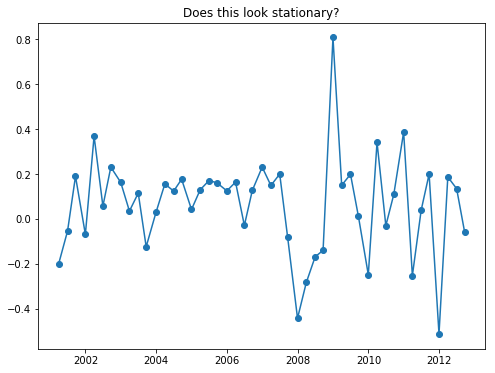

In [5]:
wine = alcohol_consumption.TotalWine
wine_diff = wine.diff(4).dropna()

plt.figure(figsize=(8, 6))
plt.plot(wine_diff, "-o")
plt.title("Does this look stationary?");

#Why do we need stationarity?
#  Models like AR, ARMA assume stationarity, e.g. constant mean/variance. Thus to use these as models, need to clean
#  data to make it stationary first!

It looks stationary enough. Let's call the result `time_series`.

In [6]:
time_series = wine_diff

## Autoregression model

In an autoregression model, values are modelled as a linear combination of the $p$ past values. An autoregressive model of order $p$, that is usually indicated as $AR(p)$ model, can be written as:

$$
y_{t} = c + (\phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \dots + \phi_{p}y_{t-p}) + e_{t},
$$

where

* `c` is the mean of the time-series
* `e_t` is the noise

The library `statsmodels` contains a `tsa` module which implements the autoregressive model.

**Task**:

* Define an `AR` model using `tsa.AR` 
* select the order using the `select_order` method. You will need to specify a maximum `p` to consider and a criterion for deciding which model is "best" 
  * AIC and BIC are common parameters which encourage "good fit" while penalising having too many parameters (complex model). 

Need stationarity to ensure all parameters, e.g. e_t, phi_1, do not depend on time.

In [12]:
#com+ add your code here
model=tsa.AR(time_series)
bestlag=model.select_order(8, 'aic')
bestlag

/Users/sujay/anaconda3/envs/cspark/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5

### Having a look at the AR model

Let's see if the AR(p) does a good job compared to the original time series. 

* use the `fit` method specifying the optimal lag found above
* use the `predict` method to generate values starting at the optimal lag
* plot the predicted results and the data, how does it look?

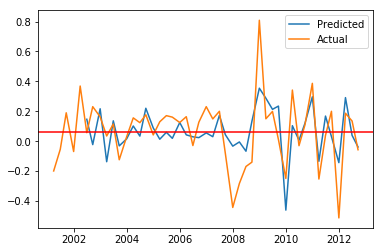

In [34]:
#com+ your code here 
fit=model.fit(bestlag)
predicted=fit.predict(start=5)

plt.plot(predicted, label='Predicted')
plt.plot(time_series, label='Actual')
plt.gca().axhline(time_series.mean(), color='red') #this is the simplest model which predicts by keeping the mean constant
plt.legend()

As for the linear regression, we may want to look at the "size" of the residuals. For example you could display the Mean Absolute Error (MAE) using `mean_absolute_error` and feeding the original time series from `optlag` onwards and compare it with the prediction.

In [29]:
#com+ add your code here to show the MAE
print(mean_absolute_error(time_series[5:], predicted))

0.13139640993766555


### Autoregression with Sklearn

Autoregression can also be implemented using `sklearn`. However, it doesn't provide direct support to handle time series, which means that you have to reorganise the data before estimating the model:

In [31]:
def organize_data(to_forecast, window, horizon=1):
    """
     Input:
      to_forecast, univariate time series organised as numpy array
      window, number of observations to use in a forecast window
      horizon, horizon of the forecast
     Output:
      X, a matrix where each row contains a forecast window
      y, the target values for each row of X
    """
    shape = to_forecast.shape[:-1] + (to_forecast.shape[-1] - window + 1, window)
    strides = to_forecast.strides + (to_forecast.strides[-1],)
    X = np.lib.stride_tricks.as_strided(to_forecast,
                                        shape=shape,
                                        strides=strides)
    y = np.array([X[i+horizon][-1] for i in range(len(X)-horizon)])
    return X[:-horizon], y

#X is just like 
#[[y1, y2, y3, y4, y5],
#[y2, y3, y4, y5, y6],
#[y3, y4, y5, y6, y7]]

X, y = organize_data(time_series, bestlag)

/Users/sujay/anaconda3/envs/cspark/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Series.strides is deprecated and will be removed in a future version
  if sys.path[0] == '':


We can now fit an autoregressive model which simply corresponds to a `LinearRegression` now:

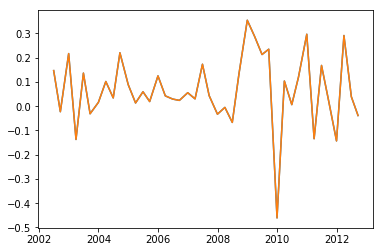

In [37]:
#com+ add your code here to fit a linear regression and show the results
lr=LinearRegression()
lr.fit(X, y)
prediction = lr.predict(X) #this is a numpy array
prediction_pd = pd.Series(prediction, index=predicted.index)

plt.plot(predicted, label='Predicted1')
plt.plot(prediction_pd, label='Predicted2')

In [39]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor()

rf.fit(X, y)
prediction_rf = rf.predict(X) #this is a numpy array
prediction_rf_pd = pd.Series(prediction_rf, index=predicted.index)

/Users/sujay/anaconda3/envs/cspark/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


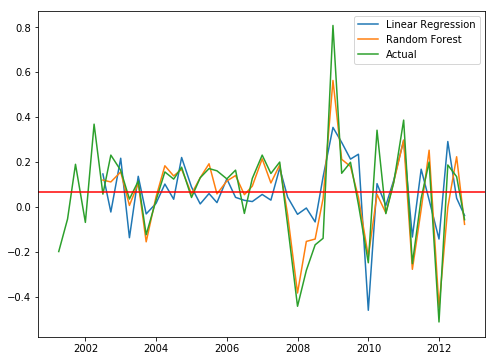

In [41]:
plt.figure(figsize=(8, 6))

plt.plot(predicted, label='Linear Regression')
plt.plot(prediction_rf_pd, label='Random Forest')
plt.plot(time_series, label='Actual')
plt.gca().axhline(time_series.mean(), color='red') #this is the simplest model which predicts by keeping the mean constant
plt.legend()

The results are the same, yay!

***TIP***: Now that you know how to implement autoregression with sklearn, you're also able to create custom autoregressive models using other regressors implemented in sklearn.

## ARMA model

AR models a point in the time series as a linear model of the previous values. The mismatch $e_t$ is assumed to be "noise".
However there could still be information in the series of $e_t$! How about we add the past errors as additionnal features?

This leads to the **ARMA** model with an autoregressive part that you will recognise and a part that corresponds to a moving average:

$$
y_{t} = c + \underbrace{ \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \dots + \phi_{p}y_{t-p} }_{AR(p)} + \underbrace{ \theta_{1}e_{t-1} + \theta_{2}e_{t-2} + \dots + \theta_{q}e_{t-q} }_{MA(q)} +e_{t},
$$

ARMA models are also implemented in `statsmodels` and their implementation is consistent with the one of AR models. 

* Create an ARMA model with `tsa.ARMA`, specify $p=3$ and $q=3$
* Fit and predict
* Display

Since the result will look almost identical to just using AR, you will want to show the MAE as well. 

Use residual from past values as additional predictors!!! Fit AR to get all the residuals, then use these for MA part.

/Users/sujay/anaconda3/envs/cspark/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


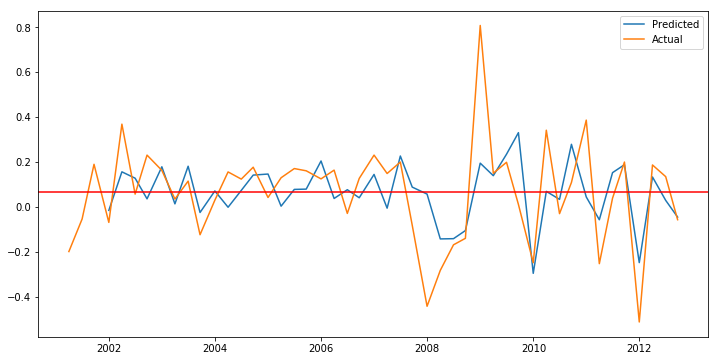

In [68]:
#com+ add your code here to fit an ARMA model
#take p=5, since it worked for AR(p) alone
params=(3,3)
model_ARMA=tsa.ARMA(time_series, params)

fit_ARMA=model_ARMA.fit()
predicted_ARMA=fit_ARMA.predict(start=params[0])

plt.figure(figsize=(12, 6))

plt.plot(predicted_ARMA, label='Predicted')
plt.plot(time_series, label='Actual')
plt.gca().axhline(time_series.mean(), color='red') #this is the simplest model which predicts by keeping the mean constant
plt.legend()

In [62]:
#com+ add your code here to show the MAE
print(mean_absolute_error(time_series[params[0]:], predicted_ARMA))

0.12720165965442176


## Forecasting

Until now we have tuned the model to *fit* the time series. 
This makes us able to find a description of the data, but doesn't give forecast.

**Note**: forecasting with time series data is **tricky** and usually basic methods do not really provide very good results (especially on realistic data). ARMA models are nice because they are simple but do not expect fantastic performances. (On the other hand, predicting the future is hard! -- who would have thought).

* Separate the time series into a training set and a test set formed of the last 8 points. 
* Fit an AR model on the training data and try to find the optimal lag using the `BIC` criterion
* fit the model, predict and show the prediction on the original time series. Did it do a good job? 
* compute the MAE

Unlike traditional tabular datasets, can't just shuffle datasets and split into 80-20 training validation sets. This will destroy chronological feature of the dataset. So, just split without shuffling.

/Users/sujay/anaconda3/envs/cspark/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/sujay/anaconda3/envs/cspark/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/sujay/anaconda3/envs/cspark/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/sujay/anaconda3/envs/cspark/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/sujay/anaconda3/envs/cspark/lib/python3.6/site-packag

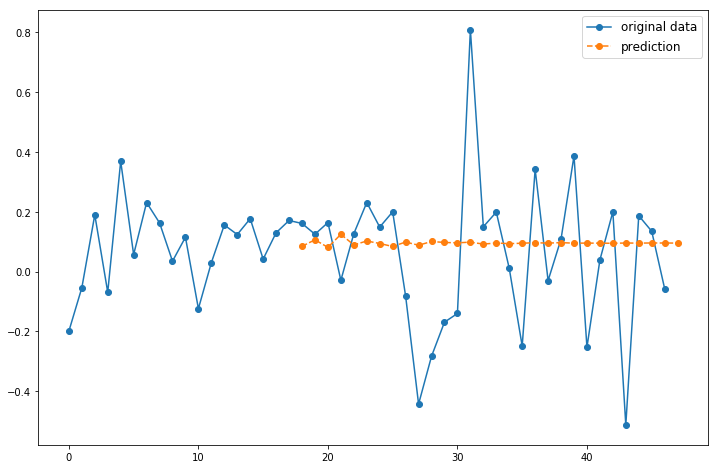

In [78]:
#com+ your code here
N=30
train = time_series[:-N]
test = time_series[-N:]

model_ar = tsa.AR(train)
bestlag = model_ar.select_order(10, ic='bic', method='mle')
arfit = model_ar.fit(maxlag=bestlag)

prediction = arfit.predict(end=len(time_series))[-len(test):]

plt.figure(figsize=(12, 8))
plt.plot(time_series.values, '-o', label="original data")
plt.plot(prediction, '--o', label='prediction')

plt.legend(fontsize=12)

In [71]:
print(mean_absolute_error(test, prediction))


0.27305698519685684


<h2>Cross-Validation for Time Series Forecasting (demo) </h2>

In this procedure, there is a series of test sets, each consisting of a single observation. The corresponding training set consists only of observations that occurred prior to the observation that forms the test set. Thus, no future observations can be used in constructing the forecast. 

Let's build a diagram to illustrate the procedure:

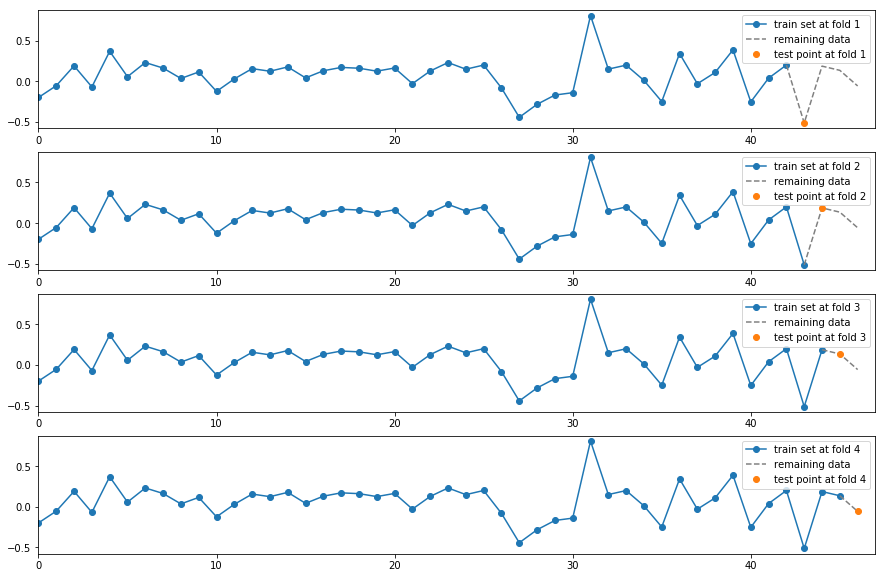

In [79]:
test_size = 4

plt.figure(figsize=(15, 10))
for i, split in enumerate(range(len(time_series)-test_size, len(time_series))):
    plt.subplot(test_size, 1, i+1)
    plt.plot(time_series.values[:-test_size+i], 
             '-o', label='train set at fold %d' % (i+1))
    plt.plot(range(len(time_series)-test_size-1+i, len(time_series)), 
             time_series.values[-test_size-1+i:], 
             '--', color='gray', label='remaining data')
    plt.plot(split, time_series.values[split], 
             'o', label='test point at fold %d' % (i+1))
    plt.xlim([0, len(time_series)])
    plt.legend()

We can now implement the cross-validation training and testing the autoregressive model at each step:

In [ ]:
start_split = 4*8
predictions = []

for split in range(start_split, len(time_series)):
    train = time_series[:split]
    test = time_series[split:]
    ar = tsa.AR(train)
    ar_result = ar.fit(maxlag=4)
    prediction = ar_result.predict(end=len(time_series))[-len(test):]
    predictions.append(prediction.values[0])

In [ ]:
len(predictions), len(time_series)-start_split
plt.plot(time_series.values, '-o', label='true')
plt.plot(range(start_split, len(time_series)), predictions, 
         '-o', label='out of sample prediction')
plt.legend();

In [ ]:
print(mean_absolute_error(time_series.values[start_split:], predictions))

Wrap up
- Using lags of the target variable as feature one can build an autoregressive model
- Adding moving average terms and differencing lead to ARIMA
- The order of the ARIMA models can be hard to tune
- Time series models can be used to describe the data and make forecast
- Cross validation can be used to estimate the error of the forecast